In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

# Define paths to training and testing datasets
train_dir = 'BreaKHis 400X/train/'
test_dir = 'BreaKHis 400X/train/'
img_size = 224

In [2]:
# Data Augmentation
data_gen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

data_gen_test = ImageDataGenerator(
    rescale=1./255
)

train_data = data_gen_train.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='categorical'
)

test_data = data_gen_test.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1148 images belonging to 2 classes.
Found 1148 images belonging to 2 classes.


In [3]:
# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Adding custom layers
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_data.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freezing the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Train the model
history = model.fit(
    train_data,
    epochs=25,
    validation_data=test_data,
    callbacks=[early_stopping, reduce_lr]
)

C:\Users\Moon-Study\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 208s 5s/step - accuracy: 0.6036 - loss: 3.9441 - val_accuracy: 0.6768 - val_loss: 0.6283 - learning_rate: 0.0010
Epoch 2/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 168s 5s/step - accuracy: 0.7080 - loss: 0.6236 - val_accuracy: 0.6768 - val_loss: 0.6463 - learning_rate: 0.0010
Epoch 3/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 166s 5s/step - accuracy: 0.6742 - loss: 0.6636 - val_accuracy: 0.6768 - val_loss: 0.6287 - learning_rate: 0.0010
Epoch 4/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 165s 5s/step - accuracy: 0.6922 - loss: 0.6398 - val_accuracy: 0.6768 - val_loss: 0.6338 - learning_rate: 0.0010
Epoch 5/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 166s 5s/step - accuracy: 0.6635 - loss: 0.6558 - val_accuracy: 0.6768 - val_loss: 0.6204 - learning_rate: 2.0000e-04
Epoch 6/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 166s 5s/step - accuracy: 0.6598 - loss: 0.6478 - val_accuracy: 0.6768 - val_loss: 0.6225 - learning_rate: 2.0000e-04
Epoch 7/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 167s 5s/step - accuracy: 0.6915 - loss: 0.6385 -

36/36 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step
              precision    recall  f1-score   support

      benign       1.00      0.00      0.00       371
   malignant       0.68      1.00      0.81       777

    accuracy                           0.68      1148
   macro avg       0.84      0.50      0.40      1148
weighted avg       0.78      0.68      0.55      1148



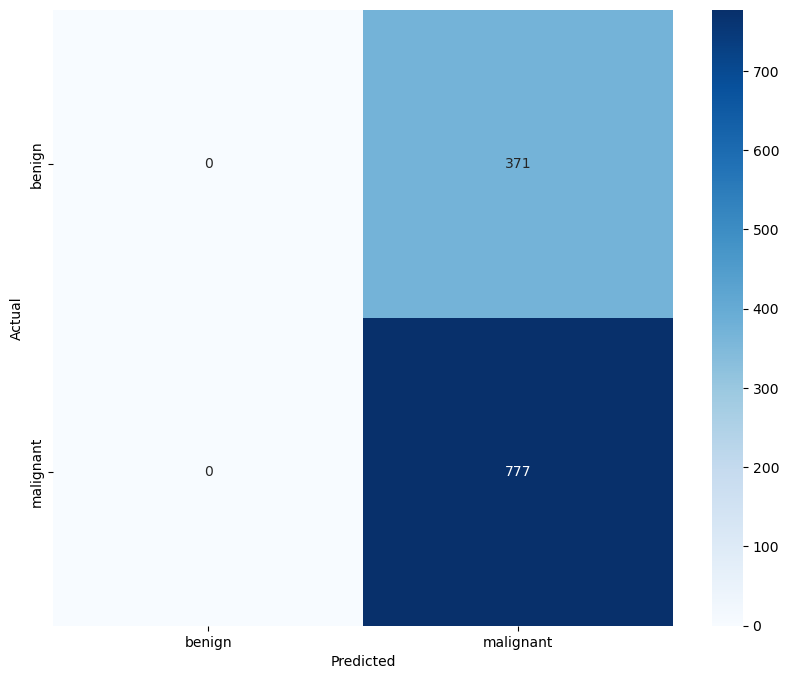

In [5]:
import seaborn as sns

# Evaluate the model
predictions = model.predict(test_data)
y_pred = np.argmax(predictions, axis=1)
y_true = test_data.classes

print(classification_report(y_true, y_pred, target_names=test_data.class_indices.keys(), zero_division=1))

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=test_data.class_indices.keys(), yticklabels=test_data.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


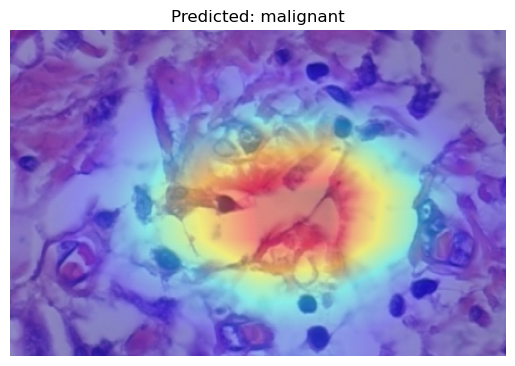

In [18]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

# Function to generate Grad-CAM heatmap
def get_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])  # Get predicted class index if not provided
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    heatmap = np.maximum(heatmap, 0)  # Remove negative values
    heatmap /= np.max(heatmap)  # Normalize heatmap to 0-1
    return heatmap, pred_index

# Load and preprocess image
img_path = 'BreaKHis 400X/test/malignant/SOB_M_DC-14-10926-400-005.png'
img = cv2.imread(img_path)
img_resized = cv2.resize(img, (224, 224))  # Resize to match model input size
img_array = np.expand_dims(img_resized, axis=0) / 255.0  # Normalize to [0, 1]

# Convert image to tensor
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)

# Make prediction
predictions = model.predict(img_tensor)
pred_index = np.argmax(predictions[0])  # Get predicted class index

# Generate Grad-CAM heatmap
last_conv_layer_name = 'conv5_block3_out'
heatmap, pred_index = get_gradcam_heatmap(img_tensor, model, last_conv_layer_name, pred_index)

# Resize the heatmap to match the input image size
heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))  # Match original image size

# Convert the heatmap to a 3D image and apply color map
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap_colored, 0.4, 0)

# Display the result
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title(f'Predicted: {list(test_data.class_indices.keys())[pred_index]}')  # Show predicted class
plt.axis('off')  # Hide axes
plt.show()
